In [1]:
!nvidia-smi

Mon Apr  7 09:57:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.03             Driver Version: 572.60         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P3             13W /   55W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[Round 50] AUC: 0.87535 | Current LR: 0.30000
[Round 100] AUC: 0.87603 | Current LR: 0.30000

[Round 120] Reducing learning rate to 0.15000
[Round 150] AUC: 0.87621 | Current LR: 0.15000

[Round 171] Reducing learning rate to 0.07500

[Round 173] Early stopping. Best AUC was 0.87624 at round 168

Test Accuracy: 80.30%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83    903599
         1.0       0.83      0.72      0.77    763068

    accuracy                           0.80   1666667
   macro avg       0.81      0.80      0.80   1666667
weighted avg       0.81      0.80      0.80   1666667



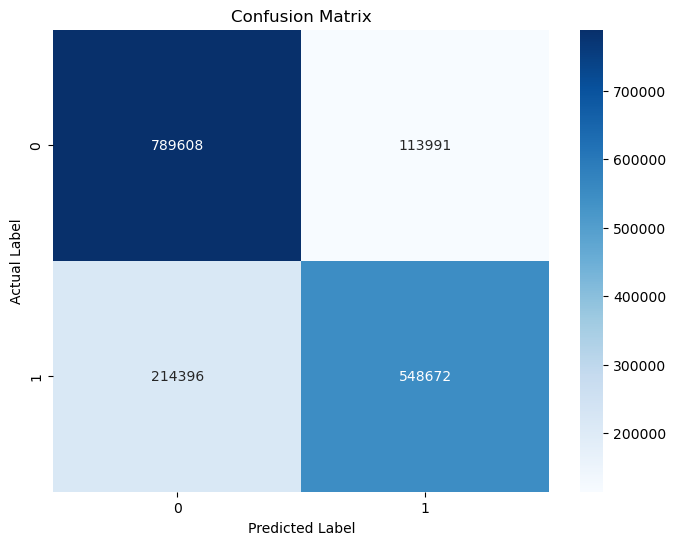

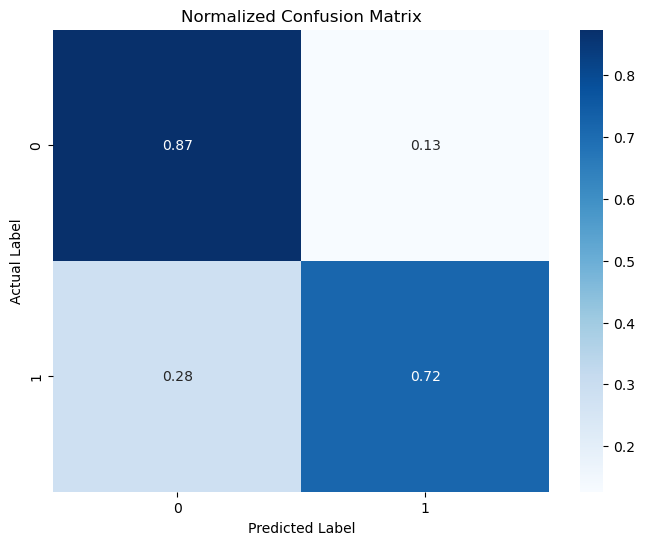

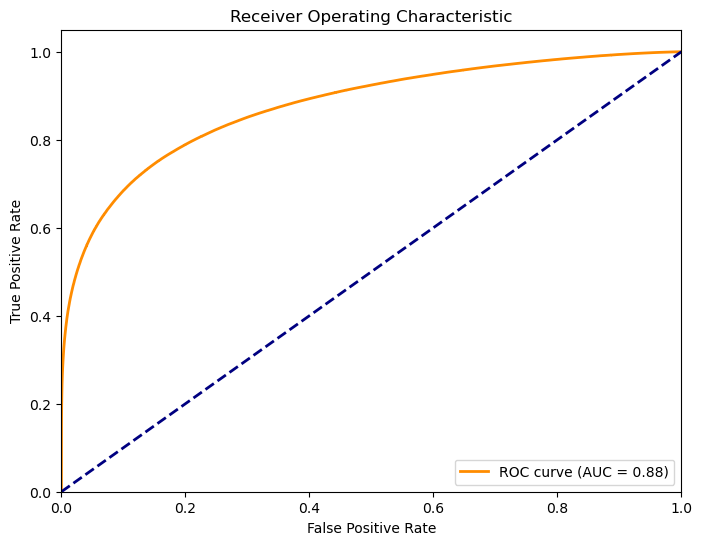

CPU times: user 12.1 s, sys: 644 ms, total: 12.7 s
Wall time: 13.8 s


In [5]:
%%time
import cudf
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# -----------------------------
# Load pre-split datasets
# -----------------------------
susy_train = cudf.read_csv("susy_train.csv")
susy_test = cudf.read_csv("susy_test.csv")

# -----------------------------
# Separate features and labels
# -----------------------------
X_train = susy_train.drop('class_label', axis=1)
y_train = susy_train['class_label']
X_test = susy_test.drop('class_label', axis=1)
y_test = susy_test['class_label']

# -----------------------------
# Parameters
# -----------------------------
params = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': 'auc',
    'learning_rate': 0.3
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# -----------------------------
# Custom Callback: Reduce LR on Plateau + Early Stop + Verbose every 50 rounds
# -----------------------------
class ReduceLROnPlateauWithEarlyStop(xgb.callback.TrainingCallback):
    def __init__(self, reduce_patience=3, stop_patience=5, reduce_factor=0.5, verbose_every=50):
        self.best_score = -np.inf
        self.best_iter = 0
        self.wait = 0
        self.lr = params['learning_rate']
        self.reduce_patience = reduce_patience
        self.stop_patience = stop_patience
        self.reduce_factor = reduce_factor
        self.verbose_every = verbose_every

    def after_iteration(self, model, epoch, evals_log):
        current_score = evals_log['Test']['auc'][-1]

        # Print every `verbose_every` rounds
        if (epoch + 1) % self.verbose_every == 0:
            print(f"[Round {epoch+1}] AUC: {current_score:.5f} | Current LR: {self.lr:.5f}")

        if current_score > self.best_score:
            self.best_score = current_score
            self.best_iter = epoch
            self.wait = 0
        else:
            self.wait += 1

            if self.wait == self.reduce_patience:
                self.lr *= self.reduce_factor
                model.set_param('learning_rate', self.lr)
                print(f"\n[Round {epoch+1}] Reducing learning rate to {self.lr:.5f}")

            if self.wait >= self.stop_patience:
                print(f"\n[Round {epoch+1}] Early stopping. Best AUC was {self.best_score:.5f} at round {self.best_iter+1}")
                return True  # Stop training

        return False  # Continue training

# -----------------------------
# Train Model
# -----------------------------
# After training:
callback = ReduceLROnPlateauWithEarlyStop(reduce_patience=3, stop_patience=5)

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtest, 'Test')],
    callbacks=[callback],
    verbose_eval=False
)


# -----------------------------
# Predictions & Evaluation
# -----------------------------
y_pred_prob = bst.predict(dtest)
y_test_pd = y_test.to_pandas()
y_pred_pd = pd.Series((y_pred_prob > 0.5).astype(int))

print("\nTest Accuracy: {:.2f}%".format(accuracy_score(y_test_pd, y_pred_pd) * 100))
print("\nClassification Report:")
print(classification_report(y_test_pd, y_pred_pd))

# Confusion Matrix
cm = confusion_matrix(y_test_pd, y_pred_pd)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Normalized Confusion Matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# ROC Curve
y_pred_prob_pd = y_pred_prob
fpr, tpr, thresholds = roc_curve(y_test_pd, y_pred_prob_pd)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
